In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import CIFAR10
from torchvision import transforms


from utils.train_utils import ModelTrainer, plot_history
from models.wide_resnet import WideResNet
from models.resnet import *
from utils.attacks import pgd

In [3]:
tr_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = CIFAR10('../data', train=True, download=True, transform=tr_transform)
ds_test = CIFAR10('../data', train=False, download=True, transform=vl_transform)

Files already downloaded and verified
Files already downloaded and verified


# Wide-ResNet

## Natural training

cuda
Epoch: 1 Validation Loss: 1.7496 accuracy: 0.4161, time: 0:02:11                
Epoch: 2 Validation Loss: 1.2635 accuracy: 0.5585, time: 0:02:11                
Epoch: 3 Validation Loss: 1.0356 accuracy: 0.6356, time: 0:02:12                
Epoch: 4 Validation Loss: 1.3792 accuracy: 0.5805, time: 0:02:11                
epochs_no_improve: 1/8
Epoch: 5 Validation Loss: 0.7997 accuracy: 0.7292, time: 0:01:51                
Epoch: 6 Validation Loss: 0.7587 accuracy: 0.7484, time: 0:01:25                
Epoch: 7 Validation Loss: 1.1710 accuracy: 0.6533, time: 0:01:25                
epochs_no_improve: 1/8
Epoch: 8 Validation Loss: 0.6306 accuracy: 0.7934, time: 0:01:25                
Epoch: 9 Validation Loss: 0.8789 accuracy: 0.7241, time: 0:01:25                
epochs_no_improve: 1/8
Epoch: 10 Validation Loss: 0.6855 accuracy: 0.7747, time: 0:01:24               
epochs_no_improve: 2/8
Epoch: 11 Validation Loss: 1.0202 accuracy: 0.7105, time: 0:01:24               
epochs_no_im

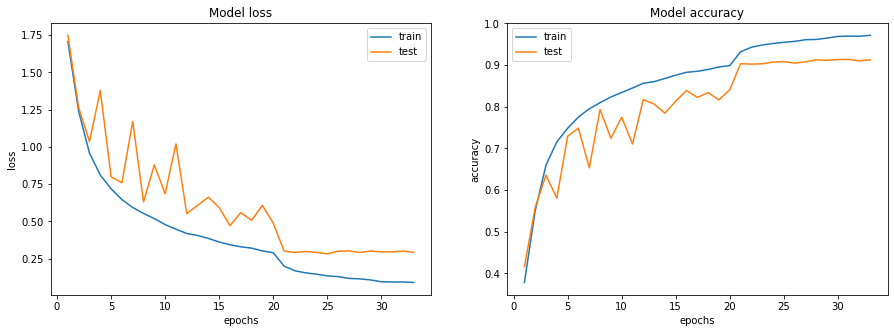

In [5]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=True, batch_size=100)

model = sparse_resnet18()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=3, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=50, patience=8)
plot_history(history)
torch.save(model.state_dict(), "../saved/sparse_resnet18.pt")

torch.cuda.empty_cache()

## Adversarial Training

In [6]:
attack_params = {
    "epsilon": 8/255,
    "alpha": 2/255,
    "num_iter": 10
}

cuda
Epoch: 1 Validation Loss: 1.2284 accuracy: 0.5930, time: 0:10:14                
Epoch: 2 Validation Loss: 1.1532 accuracy: 0.6310, time: 0:10:11                
Epoch: 3 Validation Loss: 1.1269 accuracy: 0.6411, time: 0:10:14                
Epoch: 4 Validation Loss: 1.1402 accuracy: 0.6197, time: 0:10:13                
epochs_no_improve: 1/7
Epoch: 5 Validation Loss: 1.1045 accuracy: 0.6570, time: 0:10:14                
Epoch: 6 Validation Loss: 1.0826 accuracy: 0.6349, time: 0:10:16                
Epoch: 7 Validation Loss: 1.0880 accuracy: 0.6256, time: 0:10:14                
epochs_no_improve: 1/7
Epoch: 8 Validation Loss: 1.0460 accuracy: 0.6492, time: 0:10:16                
Epoch: 9 Validation Loss: 1.1165 accuracy: 0.6241, time: 0:10:16                
epochs_no_improve: 1/7
Epoch: 10 Validation Loss: 1.0486 accuracy: 0.6591, time: 0:10:14               
epochs_no_improve: 2/7
Epoch: 11 Validation Loss: 1.0280 accuracy: 0.6712, time: 0:10:16               
Epoch: 12 Va

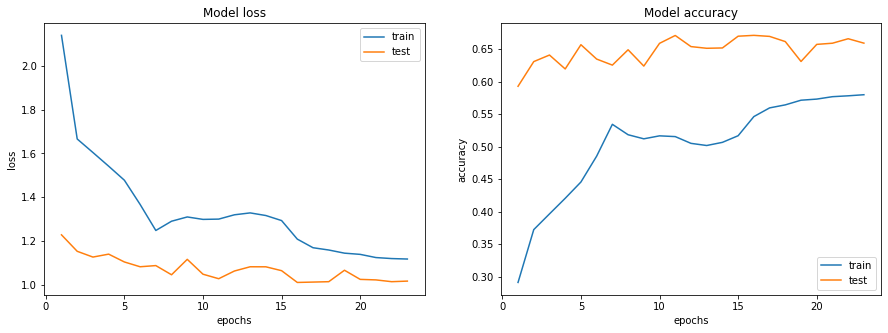

In [7]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=True, batch_size=100)
model = sparse_resnet18()
model.load_state_dict(torch.load("../saved/sparse_resnet18.pt", map_location=trainer.device))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-6, patience=3, verbose=True)

history = trainer.adv_train(model, pgd, attack_params, loss_fn, optimizer, scheduler, epochs=35, patience=7)
plot_history(history)
torch.save(model.state_dict(), "../saved/sparse_resnet18_AT.pt")

torch.cuda.empty_cache()